In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from pathlib import Path
from utils import *
from parallel_run import *

# Settings
%matplotlib inline
np.set_printoptions(precision=3)

In [3]:
PATH = Path('../INCA')
PATH.ls()

[WindowsPath('../INCA/meteo2017-2018_1H.hdf'),
 WindowsPath('../INCA/meteo2017-2018_1T.hdf'),
 WindowsPath('../INCA/pvgis.tmy')]

In [32]:
weather_file = PATH/'meteo2017-2018_1H.hdf'
tmy_file = PATH/'pvgis.tmy'
data_file = PATH/'data_1T.hdf'

Para leer estos archivos se necesita tener soporte hdf (high density format) para pandas. Hay dos archivos de datos meteo:
- 1H : paso de tiempo 1 Hora
- 1T : paso de tiempo 1 Minuto

In [33]:
weather = pd.read_hdf(weather_file, key='df')
gps_data, months, tmy = read_pvgis(tmy_file, coerce_year=2017)

Datos de  nuestro demostrador INCA en INES:
- Los datos meteo: ghi, temp_air, ... vienen de una estacion meteo tipo VAISALA y un pyrano.
- A_irradiance: es una celula de referencia cara frontal tilted (30 grados)
- A2, B2, E2 son celulas de referencia cara posterior

In [34]:
weather.head()

,ghi,temp_air,wind_speed,wind_dir,pressure,humidity,rainIntensity,hailIntensity,A_irradiance,A2_irradiance,B2_irradiance,E2_irradiance
2017-01-04 07:00:00,6.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,2.0,1.5
2017-01-04 08:00:00,29.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,7.0,7.0,7.0
2017-01-04 09:00:00,43.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,10.0,10.0,10.0
2017-01-04 10:00:00,66.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,15.0,14.0,14.5
2017-01-04 11:00:00,95.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.5,21.5,20.5,21.0


Datos de nuestro demostrador de PVGIS (satelite)

In [35]:
tmy.head()

,temp_air,humidity,ghi,dni,dhi,infrared_downwars,wind_speed,wind_dir,air_pressure
datetime,,,,,,,,,
2017-01-01 00:00:00,2.87,88.28,0.0,-0.0,0.0,259.63,1.33,350,99504
2017-01-01 01:00:00,3.59,90.07,0.0,-0.0,0.0,268.30,1.39,346,99508
2017-01-01 02:00:00,4.32,91.86,0.0,-0.0,0.0,276.97,1.45,342,99511
2017-01-01 03:00:00,5.04,93.64,0.0,-0.0,0.0,285.64,1.51,347,99517
2017-01-01 04:00:00,5.76,95.43,0.0,-0.0,0.0,294.32,1.57,351,99524


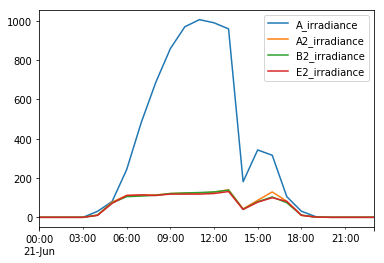

In [36]:
weather['21 June 2017'][['A_irradiance', 'A2_irradiance', 'B2_irradiance', 'E2_irradiance']].plot()

# String data

In [37]:
data = pd.read_hdf(data_file, key='df')

Data from our inverters. One inverter per module type. You will find again the reference cells that are available in the weather data. There is also a clear sky ghi column.
Our configuration are tilted 30 degrees modules facing south.
- Inv11: Fronius IG+ 50V.1 champ PV n° A / Bifacial module with with backsheet
- Inv12: Fronius IG+ 50V.1 champ PV n° B /  Bifacial modules glass/glass
- Inv15: Fronius IG+ 50V.1 champ PV n° E / Bifacial modules glass/glass
- clear_sky : ghi from pvlib clearsky model

In [38]:
data.head()

component             inv11                                              \
quantity            dcPower dcVoltage dcCurrent acActivePower acVoltage   
date                                                                      
2017-01-01 00:00:00     1.0   12051.0     162.0          -9.0  235572.0   
2017-01-01 00:00:00     0.0       0.0     162.0           0.0  235128.0   
2017-01-01 00:01:00     0.0       0.0     162.0           0.0  234732.0   
2017-01-01 00:02:00     0.0       0.0     162.0           0.0  234790.0   
2017-01-01 00:03:00     0.0       0.0     162.0           0.0  234156.0   

component                           cell_ref_A             cell_ref_A2  \
quantity            acActiveCurrent irradiance temperature  irradiance   
date                                                                     
2017-01-01 00:00:00           445.0        0.0   6552750.0         0.0   
2017-01-01 00:00:00           444.0        0.0   6552800.0         0.0   
2017-01-01 00:01:00           442.0        0.0   6552800.0         0.0   
2017-01-01 00:02:00           442.0        0.0   6552800.0         0.0   
2017-01-01 00:03:00           441.0        0.0   6552800.0         0.0   

component                        ...   inv15                      \
quantity            temperature  ... dcPower dcVoltage dcCurrent   
date                             ...                               
2017-01-01 00:00:00      -200.0  ...     0.0       0.0      77.0   
2017-01-01 00:00:00      -200.0  ...     0.0       0.0      77.0   
2017-01-01 00:01:00      -200.0  ...     0.0       0.0      78.0   
2017-01-01 00:02:00      -200.0  ...     0.0       0.0      77.0   
2017-01-01 00:03:00      -200.0  ...     0.0       0.0      77.0   

component                                                   cell_ref_E2  \
quantity            acActivePower acVoltage acActiveCurrent  irradiance   
date                                                                      
2017-01-01 00:00:00           0.0  234320.0             0.0         0.0   
2017-01-01 00:00:00           0.0  234230.0             0.0         0.0   
2017-01-01 00:01:00           0.0  233926.0             0.0         0.0   
2017-01-01 00:02:00           0.0  233686.0             0.0         0.0   
2017-01-01 00:03:00           0.0  233354.0             0.0         0.0   

component                        Tmod_E  clear_sky  
quantity            temperature       t irradiance  
date                                                
2017-01-01 00:00:00      -250.0 -2100.0        0.0  
2017-01-01 00:00:00      -300.0 -2040.0        0.0  
2017-01-01 00:01:00      -300.0 -2040.0        0.0  
2017-01-01 00:02:00      -300.0 -2040.0        0.0  
2017-01-01 00:03:00      -300.0 -2040.0        0.0  

[5 rows x 30 columns]